<a href="https://colab.research.google.com/github/kelly2657/kelly2657.github.io/blob/master/_posts/2022_04_16_californiahousing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Intro

In [ ]:
# 파이썬 3.7이상 요구
import sys
assert sys.version_info >= (3, 7)

In [ ]:
# 사이킷런 1.0.1이상 요구
import sklearn
assert sklearn.__version__ >= "1.0.1"

In [ ]:
# 이미지 확인 폰트 설정
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 데이터 구하기
캘리포니아 구역별 중간 주택가격을 예측하는 모델을 훈련시킬 것이다.

데이터를 다운로드하고 적재하는 것이 필요하다.

이를 위해 우리는 
- 데이터 저장 파일을 가져와서
- 압축을 풀고 csv파일로 저장 후 적재할 것이다.

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
# 데이터 확인
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
#범주형 특성 살펴보기
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# 수치형 특성 살펴보기
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


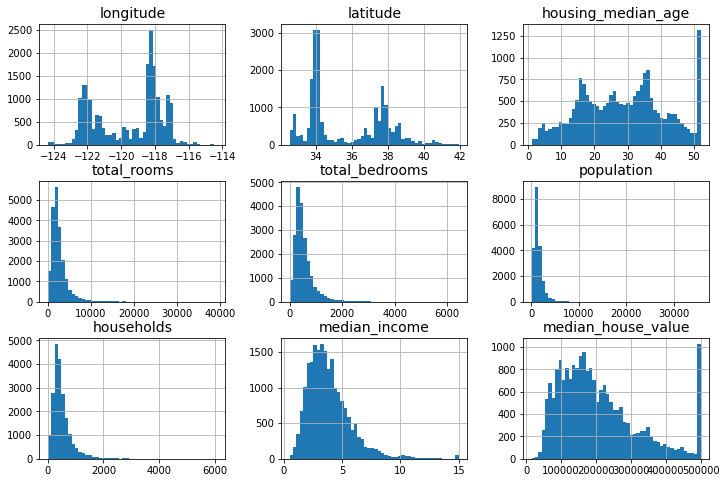

In [ ]:
# 수치형 특성별 히스토그램
housing.hist(bins=50, figsize=(12, 8))
plt.show()

테스트셋 만들기

In [ ]:
# 매번 동일한 결과 얻기 위해 랜덤시드 지정
import numpy as np

np.random.seed(42)

In [ ]:
# 20% 정도를 테스트셋으로 지정
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
# 아래 결과로 잘 나뉘어짐을 알 수 있다
print(f"train : {len(train_set)}")
print(f"test : {len(test_set)}")

train : 16512
test : 4128


__층화표집__

중간 소득을 이용해 층화표집 실행
- 소득구간을 5개로 구분

          [0, 1.5, 3.0, 4.6, 6.0, np,inf]

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

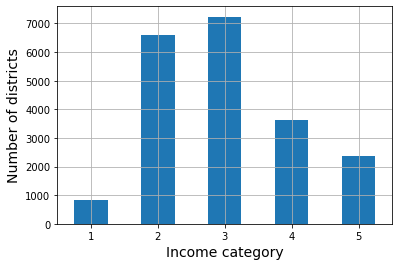

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
# 소득 기준으로 층화표집
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

층화표집은 모집단의 비율을 거의 유지한다.

하지만 무작위 추출은 비율이 좀 많이 달라진다.

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)

(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [ ]:
# 데이터 셋 되돌리기
# 필요없는 income_cat특성을 지운다.
# 이는 훈련/테스트셋 구분을 위해 사용되었고 모델훈련에는 필요가 없기 때문이다.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

__데이터 탐색&시각화__   
데이터에 대한 훈련 전 데이터를 시각화하며 탐색하는 시간을 가져보자.

이렇게 실제 훈련이 아닌 데이터로 작업을 해 데이터가 변형될 우려가 있을 경우에는 원본을 두고 그대로 복사해 사용하는 편이 좋다.

(실제로 그렇게 함)

In [ ]:
housing = strat_train_set.copy()

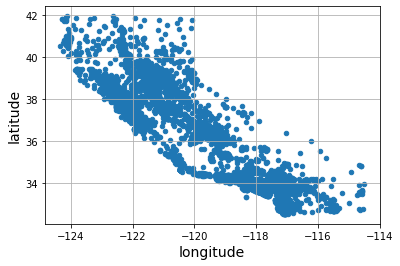

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

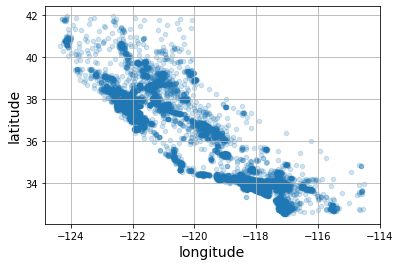

In [ ]:
# 인구 밀집지역 시각화
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

__상관관계 조사__

In [ ]:
corr_matrix = housing.corr()

In [ ]:
# 중간 주책가격과 다른 특성 간 상관관계
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

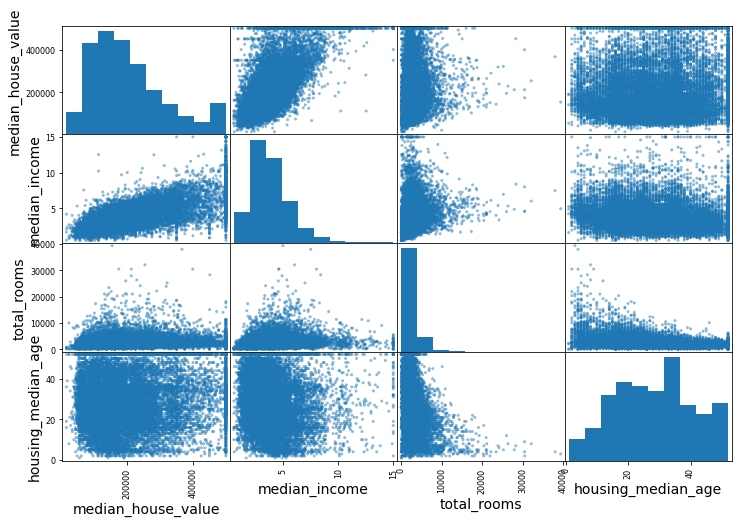

In [ ]:
# 특성 사이의 상관관계 -> 산점도
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

### 데이터 전처리
- 누락치를 확인후 채우기
- 텍스트, 범주형 특성을 다루기

중간 주택가격을 타깃값(labels)으로 지정

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
# 누락치 확인
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [ ]:
# simpleimputer변환기로 결측치 중앙값으로 채우기
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
# transform()사용해 수치형 특성 반환
X = imputer.transform(housing_num)
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

In [ ]:
# 결측치가 채워졌다.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


- 해안근접도는 문자열을 사용한다. 이를 수치화해서 모델이 훈련할 수 있도록 해야한다.

우리는 `OneHotEncoding`을 사용할 예정이다.

> 해당 범주와 관련된 특성값만 1로 변환하며 나머지 특성값은 0으로 사용한다.

In [ ]:
pd.unique(housing["ocean_proximity"])

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [ ]:
housing_cat = housing[["ocean_proximity"]]

In [ ]:
# 원핫인코딩 사용
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

변환에 사용된 범주들은 categories_ 속성, 변환된 특성 이름은 feature_names_in_ 속성에 저장

In [ ]:
print(f"변환에 사용된 범주 : {cat_encoder.categories_}")
print(f"변환된 특성 이름 : {cat_encoder.feature_names_in_}")
cat_encoder.get_feature_names_out()

변환에 사용된 범주 : [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
변환된 특성 이름 : ['ocean_proximity']


array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

__파이프라인 사용__

파이프라인을 사용하면 쉽게 데이터를 스케일링하거나 결측치를 채울 수 있다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

In [ ]:
# 군집 유사도 적용 변환기
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    # 군집화
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # fit() 함수의 반환값은 언제나 self!

    # fit() 이 찾아낸 군집별 유사도를 새로운 특성으로 추가
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    # 새롭게 생성된 특성 이름
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
# 수치형 특성 변환 파이프라인
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             StandardScaler())

In [ ]:
# 특성별 파이프라인 지정
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

# 범주형 특성 파이프라인
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

# 수치형과 범주형을 구별하여 파이프라인 구성
preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs),
                                  ])

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),     # np.object 대신 object 사용
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)



---


사이킷런 1.0.0 버전에 포함된 일부 변환기의 get_feature_names_out() 메서드가 작동하지 않는 문제가 발생한다.

이는 아래의 코드가 해결할 수 있다.

In [ ]:
# 사이킷런의 이후 버전에서는 필요하지 않을 수 있다.

def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in 1.0.0."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if self.feature_names_out is None:
                return default_get_feature_names_out(self, names)
            elif callable(self.feature_names_out):
                return self.feature_names_out(names)
            else:
                return self.feature_names_out

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


__캘리포니아 데이터셋 변환 파이프라인이다.__

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_pipeline(name=None):
    return make_pipeline(SimpleImputer(strategy="median"),
                         FunctionTransformer(column_ratio, 
                                             feature_names_out=[name]),  # sklearn 1.1 버전부터 지원부터.
                         StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             FunctionTransformer(np.log),
                             StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

# 정제와 전처리 과정 전체를 아우루는 변환 파이프라인
preprocessing = ColumnTransformer([
        ("bedrooms_ratio", ratio_pipeline("bedrooms_ratio"), 
                           ["total_bedrooms", "total_rooms"]),                 # 방당 침실 수
        ("rooms_per_house", ratio_pipeline("rooms_per_house"), 
                            ["total_rooms", "households"]),                    # 가구당 방 수
        ("people_per_house", ratio_pipeline("people_per_house"), 
                            ["population", "households"]),                     # 가구당 인원
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", 
                               "population", "households", "median_income"]),  # 로그 변환
        ("geo", cluster_simil, ["latitude", "longitude"]),                     # 구역별 군집 정보
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),     # 범주형 특성 전처리
    ],
    remainder=default_num_pipeline)                        # 중간 주택 년수(housing_median_age) 대상

In [ ]:
#이는 정제와 전처리를 동시에 한다
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
#여러 특성을 조합해 24가지의 특성이 나오는 것을 확인할 수 있다.
housing_prepared.shape

(16512, 24)

### 모델선택과 훈련

#### 선형회귀모델

In [ ]:
# 파이프라인을 사용하자.
# 위 전처리과정을 지나 모델 선택까지 한다.
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                       f...
                                                   'median_inc

In [ ]:
# 예측
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  

array([243700., 372400., 128800.,  94400., 328300.])

In [ ]:
# 실제
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
# 오차 계산
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.8%, -23.0%, 26.6%, -1.8%, -9.3%


In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

68687.89176590038

In [ ]:
# 선형회귀모델에 대한 교차검증
from sklearn.model_selection import cross_val_score
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64